# StarCat

Flip Tanedo  
Science Hack Day: SF 2017  
  
**Goal**: User inputs an image (perhaps of a cat). This notebook takes the image and identifies a set of stars that form a constellation for that image. 

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import data
from skimage import filters
import skimage.io as io
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage.color import *
from random import randint
import os

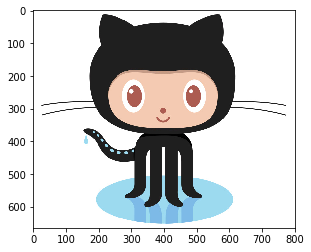

In [6]:
cat_image = io.imread('Octocat.jpg')
plt.imshow(cat_image)
plt.show()

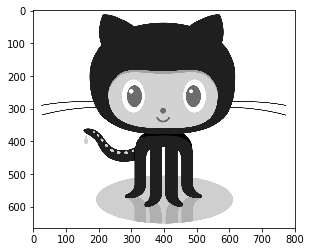

In [8]:
# We need to project down to black & white to use some
# of the scikit-image functions.
graycat = rgb2gray(cat_image)
plt.imshow(graycat, cmap='gray')
plt.show()

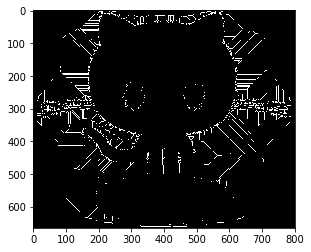

In [12]:
# This is not so helpful: we want something more sparse
skeleton = skeletonize(graycat)
plt.imshow(skeleton, cmap='gray')
plt.show()

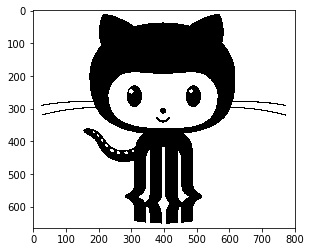

In [20]:
# http://www.scipy-lectures.org/packages/scikit-image/#histogram-based-method-otsu-thresholding
thresh = filters.threshold_mean(graycat)
binary = graycat > thresh
plt.imshow(binary, cmap=plt.cm.gray)
plt.show()

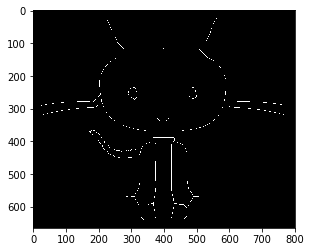

In [22]:
skeleton = skeletonize(invert(binary))
plt.imshow(skeleton, cmap='gray')
plt.show()

In [24]:
skeleton.shape

(665, 800)

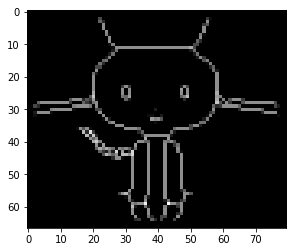

In [31]:
from skimage.measure import block_reduce
blockedcat = block_reduce(skeleton, block_size=(10,10))
plt.imshow(blockedcat, cmap='gray')
plt.show()